# **CartoCell - Training workflow (Phases 2 and 4) - BiaPy's latest version**
___  
  
**CartoCell** is a deep learning-based image processing pipeline for the high-throughput segmentation of whole epithelial cysts acquired at low resolution with minimal human intervention. The official documentation of the workflow is in [BiaPy's CartoCell tutorial](https://biapy.readthedocs.io/en/latest/tutorials/instance_seg/cartocell.html).

<figure>
<center>
<img src='https://raw.githubusercontent.com/BiaPyX/BiaPy-doc/refs/heads/master/source/img/cartocell_pipeline.png' width='800px'/>
<figcaption><b>Figure 1</b>: CartoCell processing phases (from Andrés-San Román et al., 2022).</figcaption></center>
</figure>


**This notebook replicates CartoCell's Phase 2**, i.e., it allows the segmentation of 3D epithelial cysts by training a deep learning model on a small dataset of low-resolution images (see Figure 1, Phase 2, model M1), but it is also the same workflow applied for the full dataset training (Figure 1, Phase 4, model M2).

___


**CartoCell** relies on the [BiaPy library](https://github.com/BiaPyX/BiaPy), freely available in GitHub: https://github.com/BiaPyX/BiaPy

Please note that **CartoCell** is based on a publication. If you use it successfully for your research please be so kind to cite our work:

*Andres-San Roman, J.A., Gordillo-Vazquez, C., Franco-Barranco, D., Morato, L., Fernandez-Espartero, C.H., Baonza, G., Tagua, A., Vicente-Munuera, P., Palacios, A.M., Gavilán, M.P., Martín-Belmonte, F., Annese, V., Gómez-Gálvez, P., Arganda-Carreras, I., Escudero, L.M. [CartoCell, a high-content pipeline for 3D image analysis, unveils cell morphology patterns in epithelia](https://www.cell.com/cell-reports-methods/fulltext/S2667-2375(23)00249-7). Cell Reports Methods, 3(10).*


___

<font color='red'><b>Note:</b></font> This notebook uses the **latest version of BiaPy** to replicate the pipeline proposed in the original **CartoCell** [manuscript](https://www.cell.com/cell-reports-methods/fulltext/S2667-2375(23)00249-7), thus results may vary slightly from those using the implementation of **BiaPy** at the time of publication.

## **Expected Inputs and Outputs**
___

### **Inputs**

This notebook requires five input folders:
* **Training Raw Images**: Containing the raw 3D images for training the model. A cyst per image is expected.
* **Training Label Images**: These should have instance-label 3D images for training. Their quantity and dimensions should align with the training raw images.
* **Validation Raw Images**: Containing the raw 3D images for model validation. Again, a cyst per image is expected.
* **Validation Label Images**: Containing instance-label 3D images for validation. Their quantity and dimensions should match those of the validation raw images.
* **Output Folder**: Specify a directory where the segmentation results will be saved.

### **Outputs**

If the execution is successful, two folders will be created containing:
* A **TIFF image** with the cell instances **before 3D Voronoi post-processing** for each input validation image.
* A **TIFF image** with the cell instances **after 3D Voronoi post-processing** for each input validation image.

<figure>
<center>
<img src='https://biapy.readthedocs.io/en/latest/_images/cyst_sample.gif' width='300'/>
<img src='https://biapy.readthedocs.io/en/latest/_images/cyst_instance_prediction.gif' width='300'/>
<figcaption><b>Figure 2</b>: Example of input and output images. From left to rigth: 3D TIFF input image and the resulting TIFF image with the cell instances after Voronoi post-processing</figcaption></center>
</figure>



<font color='red'><b>Note:</b></font> For testing, this notebook can be executed using the **example datasets found under 'Manage file(s) source > Option 3'**. Those samples are the ones used in our [publication](https://www.cell.com/cell-reports-methods/fulltext/S2667-2375(23)00249-7).

**Data structure**

To ensure the proper operation of the library, the input data directory tree should be something like this:

```
dataset/
├── train
│   ├── x
│   │   ├── training-0001.tif
│   │   ├── training-0002.tif
│   │   ├── . . .
│   │   └── training-9999.tif
│   └── y
│       ├── training-0001.tif
│       ├── training-0002.tif
│       ├── . . .
│       └── training-9999.tif
└── validation
    ├── x
    │   ├── validation-0001.tif
    │   ├── validation-0002.tif
    │   ├── . . .
    │   └── validation-9999.tif
    └── y
        ├── validation-0001.tif
        ├── validation-0002.tif
        ├── . . .
        └── validation-9999.tif
```

**⚠️ Warning:** Ensure that images and their corresponding masks are sorted in the same way. A common approach is to fill with zeros the image number added to the filenames (as in the example).

**Input Format Support**

This notebook is compatible with a range of input formats. You can use the following file extensions: `.tif`, `.npy` (every extension for 3D images supported by [scikit-image](https://scikit-image.org/docs/stable/api/skimage.io.html#skimage.io.imread)).

## **Prepare the Environment**
___

First, let's establish a connection with Google services. Ensure that you are **logged in to Google** before proceeding. Given that this isn't an official Google code, it's likely you'll encounter a warning about the potential risks of executing unfamiliar code. This is a standard cautionary message.


## **Check for GPU Access**
---

By default, the session is configured to use Python 3 with GPU acceleration. However, it's a good practice to double-check these settings:

1. Navigate to **Runtime** in the top menu and select **Change the Runtime type**.
2. Ensure the following settings:
   - **Runtime type:** Python 3 (This program is written in the Python 3 programming language.)
   - **Accelerator:** GPU (Graphics Processing Unit)

This will ensure that you're using Python 3 and taking advantage of GPU acceleration.


## **Install BiaPy**
---
This might take some minutes depending on the current installed libraries in Colab.


In [ ]:
#@markdown ##Play to install BiaPy and its dependences
# Install latest release of BiaPy
!pip install biapy==3.6.7

# Then install Pytorch + CUDA 11.8
!pip install torch==2.4.0 torchvision==0.19.0 torchaudio==2.4.0 --index-url https://download.pytorch.org/whl/cu118

# Finally install some packages that rely on the Pytorch installation
!pip install timm==1.0.14 pytorch-msssim torchmetrics[image]==1.4.*


import os
import sys
import numpy as np
from tqdm.notebook import tqdm
from skimage.io import imread
import ipywidgets as widgets
from ipywidgets import Output
from biapy import BiaPy

changed_source = False

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.1/411.1 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.0/203.0 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 80.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 66.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.9/434.9 kB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 75.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/

## **Manage File(s) Source**
---

The input folder can be provided using three different options:
1. **Direct Upload**: Directly upload the desired folder.
2. **Google Drive**: Use a folder stored in your Google Drive.
3. **Sample Data**: Use a sample dataset provided by us.

The steps you'll need to follow vary depending on your chosen option. These steps are detailed in the subsequent sections.



### **Option 1: Upload Files from Your Local Machine**
---

When you select this option, you'll be prompted to upload your files to Colab. Once uploaded, they will be stored in the `/content/input/` directory.


In [ ]:
#@markdown ##Play the cell to upload local files (train raw images)
from google.colab import files
!mkdir -p /content/input/train/x
%cd /content/input/train/x
uploaded = files.upload()
%cd /content

In [ ]:
#@markdown ##Play the cell to upload local files (train label images)

from google.colab import files
!mkdir -p /content/input/train/y
%cd /content/input/train/y
uploaded = files.upload()
%cd /content

In [ ]:
#@markdown ##Play the cell to upload local files (validation raw images)

from google.colab import files
!mkdir -p /content/input/validation/x
%cd /content/input/validation/x
uploaded = files.upload()
%cd /content

In [ ]:
#@markdown ##Play the cell to upload local files (validation label images)

from google.colab import files
!mkdir -p /content/input/validation/y
%cd /content/input/validation/y
uploaded = files.upload()
%cd /content

### **Option 2: Mount Your Google Drive**
---

If you wish to use this notebook with data from your Google Drive, you'll first need to mount the drive to this notebook.

Execute the cell below to initiate the Google Drive mounting process. A link will be displayed click on it. In the new browser window that opens, choose your drive and click 'Allow'. Copy the code that appears, return to this notebook, paste the code into the cell, and press 'Enter'. This action grants Colab access to your Google Drive data.

After this process, you can access your data via the **Files** tab, located on the top left of this notebook.


In [ ]:
#@markdown ##Play the cell to connect your Google Drive to Colab

#@markdown * Click on the URL.

#@markdown * Sign in your Google Account.

#@markdown * Copy the authorization code.

#@markdown * Enter the authorization code.

#@markdown * Click on "Files" site on the right. Refresh the site. Your Google Drive folder should now be available here as "drive".

# mount user's Google Drive to Google Colab.
from google.colab import drive
drive.mount('/content/gdrive')

### **Option 3: Download an Example Dataset**
---

Don't you have data readily available but still want to test the notebook? No problem! Simply execute the following cell to download a sample dataset.

Specifically, we'll use the **training and validation sets used to train the M1 model** in our manuscript and publicly available in [Zenodo](https://zenodo.org/records/10973241). Notice the M2 training dataset will also be downloaded.


In [ ]:
#@markdown ##Play to download the example dataset (M1 training and validation sets)
!pip install gdown==5.1.0 --quiet
import gdown
import os

os.chdir('/content/')

print( 'Downloading original CartoCell dataset...')

gdown.download("https://drive.google.com/uc?id=1eScAB6mpmPeQcirR5xK6Rkz4AAobsG_X", "CartoCell.zip", quiet=True)

!unzip -q CartoCell.zip
!rm CartoCell.zip

print( 'Dataset downloaded and unzipped under /content/CartoCell')


Dataset downloaded and unzipped under /content/CartoCell


## **Paths for Input Images and Output Files**
___

Depending on the option you chose for managing file sources, you'll set your paths differently:

- **Option 1 (Upload from Local Machine)**:
  - Set `train_data_path` to `/content/input/train/x`
  - Set `train_data_gt_path` to `/content/input/train/y`
  - Set `val_data_path` to `/content/input/val/x`
  - Set `val_data_gt_path` to `/content/input/val/y`
  - Set `output_path` to `/content/out`
  
- **Option 2 (Use Google Drive Data)**:
  - Insert the paths to your input files and your desired output directory here, i.e., `/content/gdrive/MyDrive/...`.
  
- **Option 3 (Use Our Sample Data)**:
  - Set `train_data_path` to `/content/CartoCell/train_M1/x`
  - Set `train_data_gt_path` to `/content/CartoCell/train_M1/y`
  - Set `val_data_path` to `/content/CartoCell/validation/x`
  - Set `val_data_gt_path` to `/content/CartoCell/validation/y`
  - Set `output_path` to `/content/out`

  **Note**: Ensure you download your results from the `/content/out` directory after the process!

**Helpful Tip**: If you're unsure about the paths to your folders, look at the top left of this notebook for a small folder icon. Navigate through the directories until you locate your desired folder. Right-click on it and select "Copy Path" to copy the folder's path.

In [ ]:
#@markdown #####Path to train images
train_data_path = '/content/CartoCell/train_M1/x' #@param {type:"string"}
#@markdown #####Path to train instances
train_data_gt_path = '/content/CartoCell/train_M1/y' #@param {type:"string"}
#@markdown #####Path to validation images
val_data_path = '/content/CartoCell/validation/x' #@param {type:"string"}
#@markdown #####Path to validation instances
val_data_gt_path = '/content/CartoCell/validation/y' #@param {type:"string"}
#@markdown #####Path to store the resulting images (it'll be created if not existing):
output_path = '/content/output' #@param {type:"string"}

## **Dataset Visualization**
---

In [ ]:
# @markdown ## Play to visualize some data samples
# @markdown Select the *Set* (training or validation) to visualize samples from, and use the *Image index* and *Z value* scrolls to navigate among volumes and slices. **Note**: it might take a few seconds to refresh the images.
%matplotlib inline
import matplotlib
import numpy as np
from matplotlib import pyplot as plt
from skimage.io import imread
import os
from ipywidgets import interact, IntSlider, Layout, Dropdown, VBox, Output

# Initialize global attributes
input_path = train_data_path
gt_path = train_data_gt_path

instance_id = 0

ids_input = sorted(next(os.walk(input_path))[2])
input_img = imread(os.path.join(input_path, ids_input[0]))

ids_gt = sorted(next(os.walk(gt_path))[2])
gt_img = imread(os.path.join(gt_path, ids_gt[0])).astype(np.uint16)

# Create random color map
vals = np.linspace(0,1,256)
np.random.shuffle(vals)
cmap = plt.cm.colors.ListedColormap(plt.cm.gist_rainbow(vals))
cmap.colors[0] = [0., 0., 0., 1.] # set background to black

# Initialize widgets

# Dropdown widget to choose training or test validation
dropdown = Dropdown(
    options=['training-set', 'validation-set'],
    value='training-set',
    description='Set:',
    disabled=False,
)

# Slider widget to choose instance
slider= IntSlider(
    value=0,
    min=1,
    max=len(ids_input),
    step=1,
    description='Image index:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    layout=Layout(width='500px', margin = '0 0 0 10px')
)

slider.style.description_width = 'initial'
slider.style.handle_color='blue'

# Slider widget to choose Z value
sliderZ= IntSlider(
    value=0,
    min=1,
    max=len(input_img),
    step=1,
    description='Z value:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    layout=Layout(width='500px', margin = '0 0 0 10px')
)

sliderZ.style.description_width = 'initial'
sliderZ.style.handle_color='blue'

# Initialize Output instance to handle code output cell
output = Output()

# Function to update paths (input_path, gt_path) and image IDs (ids_input, ids_gt) depending on dropdown
def update_paths(change):
    global input_path, gt_path
    if change.new == 'validation-set':
        input_path = val_data_path
        gt_path = val_data_gt_path
    else:
        input_path = train_data_path
        gt_path = train_data_gt_path

    global ids_input, ids_gt
    ids_input = sorted(next(os.walk(input_path))[2])
    try:
        ids_gt = sorted(next(os.walk(gt_path))[2])
    except StopIteration:
        ids_gt = []

    # Reset slider value to 1 when dropdown changes
    slider.value = 1
    slider.max = len(ids_input)
    update_id({'new': 1})

# Function to update image and label set (input_img, gt_img, instance_id) depending on slider value
def update_id(change):
    index = change['new']

    global instance_id
    instance_id = index - 1

    global input_path, ids_input, input_img, gt_path, ids_gt, gt_img
    input_img_path = os.path.join(input_path, ids_input[instance_id])
    input_img = imread(input_img_path)

    if ids_gt != []: # If StopIteration exception was not thrown
        gt_img_path = os.path.join(gt_path, ids_gt[instance_id])
        gt_img = imread(gt_img_path).astype(np.uint16)
    else:
        gt_img = None

    sliderZ.value = 1
    sliderZ.max = len(input_img)
    display_images({'new': 1})

# Function to display images depending on sliderZ value
def display_images(change):
    with output:
        output.clear_output(wait=True)
        index = change['new']

        global input_img, gt_img, instance_id

        # Display images
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.title(f"Input image: {instance_id+1}, Z: {index}")
        plt.imshow(input_img[index-1], cmap='gray')
        # plt.axis('off')

        # # # Print sample path to ensure the image displayed is correct
        # global input_path, ids_input
        # print(os.path.join(input_path, ids_input[instance_id]))

        if gt_img is not None:
            plt.subplot(1, 2, 2)
            plt.title("Label")
            plt.imshow(gt_img[index-1], cmap=cmap, interpolation='nearest')
            # plt.axis('off')

            # # # Print label path to ensure the image displayed is correct
            # global gt_path, ids_gt
            # print(os.path.join(gt_path, ids_gt[instance_id]))

        else:
            print("No labels for this set.")

        plt.show()


# Create an VBox to hold the dropdown and slider
controls = VBox([dropdown, slider, sliderZ])
display(controls, output)

# Link widgets to functions
dropdown.observe(update_paths, names='value')
slider.observe(update_id, names='value')
sliderZ.observe(display_images, names='value')

# Initial display
display_images({'new': slider.value})

Output()

## **Train the model (Phase 2 / 4)**
----
Next, we will train the model using all the training samples and will stop if the results are improving on the set-aside validation samples.

This step corresponds to **Phase 2** in the publication if the training samples are those of the **M1 model**, and to **Phase 4** if the training samples are those of the **M2 model**.



### **Select your parameters**
---

In the original publication of CartoCell, the training of the **M1 model** was performed 1300 epochs and using 100 as patience (with no learning rate scheduler). Since those values involve several hours of training, **here we propose another parameter setting** to obtain preliminary results faster (~30 minutes).

#### **Basic training parameters**
* **`number_of_epochs`:** Input how many epochs (rounds) the network will be trained. For the example dataset, preliminary results can already be observed after 30 epochs, using the one-cycle learning scheduler. **Default value: 30** (Publication value: 1300).

* **`patience`:**  Input how many epochs you want to wait without the model improving its results in the validation set to stop training. When using the one-cycle learning scheduler, this value should be equal to the number of epochs. **Default value: 30** (Publication value: 100).

#### **Advanced Parameters - experienced users only**

* **`batch_size:`** This parameter defines the number of patches seen in each training step. Reducing or increasing the **batch size** may slow or speed up your training, respectively, and can influence network performance. **Default value: 2** (Publication value: 2).

* **`patch_size_xy`:** Input the XY size of the patches use to train your model (length in pixels in X and Y). The value should be smaller or equal to the dimensions of the image. **Default value: 80** (Publication value: 80).

* **`patch_size_z`:** Input the Z size of the patches use to train your model (length in pixels in Z). The value should be smaller or equal to the dimensions of the image. **Default value: 80** (Publication value: 80).

* **`optimizer`:** Select the optimizer used to train your model. Options: ADAM, ADAMW, Stochastic Gradient Descent (SGD). ADAM usually converges faster, while ADAMW provides a balance between fast convergence and better handling of weight decay regularization. SGD is known for better generalization. **Default value: ADAMW** (Publication value: ADAM).

* **`initial_learning_rate`:** Input the initial value to be used as learning rate. This value is taken as the maximum learning rate value when you select a "One cycle" scheduler (see below). **Default value: 0.001** (Publication value: 0.0001).

* **`learning_rate_scheduler`:** Select to adjust the learning rate between epochs. Options: "None", "Reduce on plateau", "One cycle", "Warm-up cosine decay". **Default value: One cycle** (Publication value: None).

In [ ]:
#@markdown ### Basic training parameters:
number_of_epochs =  30#@param {type:"number"}
patience =  30#@param {type:"number"}

#@markdown ### Advanced training parameters:

batch_size =  2#@param {type:"number"}
patch_size_xy = 80 #@param {type:"number"}
patch_size_z = 80 #@param {type:"number"}

#anisotropic_data = False #@param {type:"boolean"}

optimizer = "ADAMW" #@param ["ADAM", "SGD","ADAMW"]
initial_learning_rate = 0.001 #@param {type:"number"}
learning_rate_scheduler = "One cycle" #@param ["None", "Reduce on plateau","One cycle", "Warm-up cosine decay"]

checkpoint_path = ''

In [ ]:
#@markdown ##OPTIONAL: Play the cell to upload initial model weights
#@markdown Use this option to start the training from a **pre-trained model** if you have one. Otherwise, skip this cell.

#@markdown **Important**: remember the weights must correspond to the selected architecture, patch size and number of input channels. Otherwise, an error will be shown when training.
from google.colab import files

#s.chdir('/content/')

uploaded = files.upload()

checkpoint_path = '/content/' + list(uploaded.keys())[0]

# open previously configured file, if exists
job_name = model_name
yaml_file = "/content/"+str(job_name)+".yaml"

# edit previous configuration file if it exists to load the checkpoint model
if os.path.exists( yaml_file ):
    import yaml
    with open( yaml_file, 'r') as stream:
        try:
            biapy_config = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    biapy_config['PATHS'] = {}
    biapy_config['PATHS']['CHECKPOINT_FILE'] = checkpoint_path
    biapy_config['MODEL'] = {}
    biapy_config['MODEL']['LOAD_CHECKPOINT'] = True

    # save file
    with open( yaml_file, 'w') as outfile:
        yaml.dump(biapy_config, outfile, default_flow_style=False)

print( "Pre-trained model loaded and ready to re-train.")

### **Train the model**
---

In [ ]:
#@markdown ##Play to train the model

import os
import errno

os.chdir('/content/')

job_name = "cartocell_training"
input_channels = 1

yaml_file = "/content/"+str(job_name)+".yaml"

# remove previous configuration file if it exists with the same name
if os.path.exists( yaml_file ):
    os.remove( yaml_file )

# remove template file it is exists
template_file = 'cartocell_training_latest.yaml'
if os.path.exists( template_file ):
    os.remove( template_file )

# Download template file
!wget https://raw.githubusercontent.com/BiaPyX/BiaPy/master/templates/instance_segmentation/CartoCell_paper/cartocell_training_latest.yaml &> /dev/null

# Check folders before modifying the .yaml file
if not os.path.exists(train_data_path):
    raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), train_data_path)
ids = sorted(next(os.walk(train_data_path))[2])
if len(ids) == 0:
    raise ValueError("No images found in dir {}".format(train_data_path))
if not os.path.exists(train_data_gt_path):
    raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), train_data_gt_path)
ids = sorted(next(os.walk(train_data_gt_path))[2])
if len(ids) == 0:
    raise ValueError("No images found in dir {}".format(train_data_gt_path))

# Check folders before modifying the .yaml file
if not os.path.exists(val_data_path):
    raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), val_data_path)
ids = sorted(next(os.walk(val_data_path))[2])
if len(ids) == 0:
    raise ValueError("No images found in dir {}".format(val_data_path))


# open template configuration file
import yaml
with open( template_file, 'r') as stream:
    try:
        biapy_config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

# update paths to data
biapy_config['DATA']['TRAIN']['PATH'] = train_data_path
biapy_config['DATA']['TRAIN']['GT_PATH'] = train_data_gt_path
biapy_config['DATA']['VAL']['FROM_TRAIN'] = True
biapy_config['DATA']['VAL']['PATH'] = val_data_path
biapy_config['DATA']['VAL']['GT_PATH'] = val_data_gt_path
# use validation set as test to show some results
biapy_config['DATA']['TEST']['PATH'] = val_data_path
biapy_config['DATA']['TEST']['GT_PATH'] = val_data_gt_path


# update data patch size
biapy_config['DATA']['PATCH_SIZE'] = '('+str(patch_size_z)+', '+ str(patch_size_xy)+', '+ str(patch_size_xy)+ ', ' + str(input_channels)+')'

# update training parameters
biapy_config['TRAIN']['EPOCHS'] = number_of_epochs
biapy_config['TRAIN']['PATIENCE'] = patience
biapy_config['TRAIN']['BATCH_SIZE'] = batch_size
biapy_config['TRAIN']['OPTIMIZER'] = optimizer
biapy_config['TRAIN']['LR'] = initial_learning_rate

# make sure the plots are created when using few epochs
if number_of_epochs < 10:
    biapy_config['LOG'] = {}
    biapy_config['LOG']['CHART_CREATION_FREQ'] = 1

# learning rate scheduler
if learning_rate_scheduler == 'One cycle':
    biapy_config['TRAIN']['LR_SCHEDULER'] = {}
    biapy_config['TRAIN']['LR_SCHEDULER']['NAME'] = 'onecycle'
elif learning_rate_scheduler == 'Warm-up cosine decay':
    biapy_config['TRAIN']['LR_SCHEDULER'] = {}
    biapy_config['TRAIN']['LR_SCHEDULER']['NAME'] = 'warmupcosine'
    biapy_config['TRAIN']['LR_SCHEDULER']['MIN_LR'] = 0.0
    biapy_config['TRAIN']['LR_SCHEDULER']['WARMUP_COSINE_DECAY_EPOCHS'] = 0
elif learning_rate_scheduler == 'Reduce on plateau':
    biapy_config['TRAIN']['LR_SCHEDULER'] = {}
    biapy_config['TRAIN']['LR_SCHEDULER']['NAME'] = 'reduceonplateau'
    biapy_config['TRAIN']['LR_SCHEDULER']['REDUCEONPLATEAU_FACTOR'] = 0.5
    biapy_config['TRAIN']['LR_SCHEDULER']['REDUCEONPLATEAU_PATIENCE'] = 5
    biapy_config['TRAIN']['LR_SCHEDULER']['MIN_LR'] = 0.00001

# update test parameters
biapy_config['TEST']['FULL_IMG'] = False
biapy_config['DATA']['TEST']['LOAD_GT'] = True
biapy_config['TEST']['ENABLE'] = True

# model weights
if checkpoint_path != '':
    biapy_config['PATHS'] = {}
    biapy_config['PATHS']['CHECKPOINT_FILE'] = checkpoint_path
    biapy_config['MODEL'] = {}
    biapy_config['MODEL']['LOAD_CHECKPOINT'] = True


# save file
with open( yaml_file, 'w') as outfile:
    yaml.dump(biapy_config, outfile, default_flow_style=False)

print( "Training configuration finished.")

# Run the code
biapy = BiaPy(f'/content/{job_name}.yaml', result_dir=output_path, name=job_name, run_id=1, gpu=0)
biapy.run_job()

[14:29:25.689585] Training configuration finished.
[14:29:25.701704] Date: 2024-12-09 14:29:25
[14:29:25.701806] Arguments: Namespace(config='/content/cartocell_training.yaml', result_dir='/content/output', name='cartocell_training', run_id=1, gpu=0, world_size=1, local_rank=-1, dist_on_itp=False, dist_url='env://', dist_backend='nccl')
[14:29:25.703094] Job: cartocell_training_1
[14:29:25.703158] Python       : 3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]
[14:29:25.703197] PyTorch:  2.4.0+cu118
[14:29:25.705943] Not using distributed mode
[14:29:25.711908] Configuration details:
[14:29:25.711968] AUGMENTOR:
  AFFINE_MODE: reflect
  AUG_NUM_SAMPLES: 10
  AUG_SAMPLES: True
  BRIGHTNESS: True
  BRIGHTNESS_FACTOR: (0.1, 0.15)
  BRIGHTNESS_MODE: 3D
  CBLUR_DOWN_RANGE: (2, 8)
  CBLUR_INSIDE: True
  CBLUR_SIZE: (0.2, 0.4)
  CHANNEL_SHUFFLE: False
  CMIX_SIZE: (0.2, 0.4)
  CNOISE_NB_ITERATIONS: (1, 3)
  CNOISE_SCALE: (0.05, 0.1)
  CNOISE_SIZE: (0.2, 0.4)
  CONTRAST: False
  CONTRAST_FAC

100%|██████████| 68/68 [00:00<00:00, 493.76it/s]


[14:29:26.391120] *** Loaded data shape is (68, 80, 80, 80, 1)
[14:29:26.393257] * Loading train GT . . .


100%|██████████| 68/68 [00:00<00:00, 160.83it/s]


[14:29:26.823377] *** Loaded data shape is (68, 80, 80, 80, 3)
[14:29:26.823476] * Loading validation images . . .


100%|██████████| 8/8 [00:00<00:00, 464.04it/s]


[14:29:26.847645] *** Loaded data shape is (8, 80, 80, 80, 1)
[14:29:26.847730] * Loading validation GT . . .


100%|██████████| 8/8 [00:00<00:00, 177.04it/s]


[14:29:26.901918] *** Loaded data shape is (8, 80, 80, 80, 3)
[14:29:26.902016] ### LOAD RESULTS ###
[14:29:26.902061] *** Loaded train data shape is: (68, 80, 80, 80, 1)
[14:29:26.902095] *** Loaded train GT shape is: (68, 80, 80, 80, 3)
[14:29:26.902129] *** Loaded validation data shape is: (8, 80, 80, 80, 1)
[14:29:26.902163] *** Loaded validation GT shape is: (8, 80, 80, 80, 3)
[14:29:26.902191] ### END LOAD ###
[14:29:26.902254] ###############
[14:29:26.902288] # Build model #
[14:29:26.902317] ###############
[14:29:26.978114] ##############################
[14:29:26.978206] #  PREPARE TRAIN GENERATORS  #
[14:29:26.978252] ##############################
[14:29:26.978498] Initializing train data generator . . .
[14:29:26.983192] Checking which channel of the mask needs normalization . . .
[14:29:28.870020] Normalization config used for X: {'type': 'div', 'mask_norm': 'as_mask', 'enable': True, 'orig_dtype': dtype('uint8'), 'div': 1}
[14:29:28.871173] Normalization config used for

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/imgaug/augmenters/base.py:49: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (80, 80, 80) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  ia.warn(

  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
100%|█████████

[14:29:33.189019] Number of workers: 5
[14:29:33.189105] Accumulate grad iterations: 1
[14:29:33.189143] Effective batch size: 2
[14:29:33.189213] Sampler_train = <torch.utils.data.distributed.DistributedSampler object at 0x7b4ad980f8e0>
[14:29:33.189521] #######################
[14:29:33.189720] # Prepare logging tool #
[14:29:33.189771] #######################
[14:29:33.197288] AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.02
)
[14:29:33.197653] #####################
[14:29:33.198286] #  TRAIN THE MODEL  #
[14:29:33.198329] #####################
[14:29:33.198380] Start training in epoch 1 - Total: 30
[

/usr/local/lib/python3.10/dist-packages/biapy/engine/train_engine.py:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


[14:29:35.386224] Epoch: [1]  [ 0/34]  eta: 0:01:14  loss: 4.5285 (4.5285)  IoU (B channel): 0.1711 (0.1711)  IoU (C channel): 0.1446 (0.1446)  IoU (M channel): 0.0675 (0.0675)  lr: 0.000040  iter-time: 2.1838
[14:29:49.682584] Epoch: [1]  [10/34]  eta: 0:00:35  loss: 2.4723 (2.8493)  IoU (B channel): 0.3323 (0.2875)  IoU (C channel): 0.3520 (0.2894)  IoU (M channel): 0.3273 (0.2575)  lr: 0.000043  iter-time: 1.4981
[14:30:04.109441] Epoch: [1]  [20/34]  eta: 0:00:20  loss: 2.3392 (2.5948)  IoU (B channel): 0.3592 (0.3199)  IoU (C channel): 0.3504 (0.3144)  IoU (M channel): 0.3622 (0.3089)  lr: 0.000051  iter-time: 1.4359
[14:30:18.696663] Epoch: [1]  [30/34]  eta: 0:00:05  loss: 2.2235 (2.4374)  IoU (B channel): 0.3749 (0.3426)  IoU (C channel): 0.3445 (0.3196)  IoU (M channel): 0.3857 (0.3363)  lr: 0.000064  iter-time: 1.4502
[14:30:23.095256] Epoch: [1]  [33/34]  eta: 0:00:01  loss: 2.1854 (2.4071)  IoU (B channel): 0.3774 (0.3450)  IoU (C channel): 0.3307 (0.3184)  IoU (M channel):

/usr/local/lib/python3.10/dist-packages/biapy/engine/train_engine.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


[14:30:24.169892] Epoch: [1]  [0/4]  eta: 0:00:03  loss: 4.1795 (4.1795)  IoU (B channel): 0.0004 (0.0004)  IoU (C channel): 0.0921 (0.0921)  IoU (M channel): 0.0092 (0.0092)  iter-time: 0.8663
[14:30:25.583056] Epoch: [1]  [3/4]  eta: 0:00:00  loss: 3.7723 (3.9948)  IoU (B channel): 0.0003 (0.0004)  IoU (C channel): 0.0921 (0.1082)  IoU (M channel): 0.0096 (0.0099)  iter-time: 0.5697
[14:30:25.690562] Epoch: [1] Total time: 0:00:02 (0.5969 s / it)
[14:30:25.691482] [Val] averaged stats: loss: 3.7723 (3.9948)  IoU (B channel): 0.0003 (0.0004)  IoU (C channel): 0.0921 (0.1082)  IoU (M channel): 0.0096 (0.0099)
[14:30:25.693348] Val loss improved from inf to 3.9948313236236572, saving model to /content/output/cartocell_training/checkpoints/cartocell_training_1-checkpoint-best.pth
[14:30:25.749966] [Val] best loss: 3.9948 best  IoU (B channel): 0.0004 IoU (C channel): 0.1082 IoU (M channel): 0.0099 
[14:30:25.752801] [Time] 52.6s 52.6s/27.2m

[14:30:25.752892] ~~~ Epoch 2/30 ~~~

[14:30:2

  0%|          | 0/2 [00:00<?, ?it/s]

[14:58:15.845002] Reflected from (51, 126, 126, 1) to (80, 126, 126, 1)
[14:58:15.851340] Reflected from (51, 126, 126, 3) to (80, 126, 126, 3)
[14:58:15.856684] Processing image: CYST 7d Filt 3well Pha,Bcat,DAPI 40x Z4 15.7.19 3a.tif
[14:58:15.857769] ### 3D-OV-CROP ###
[14:58:15.857848] Cropping (80, 126, 126, 1) images into (80, 80, 80, 1) with overlapping . . .
[14:58:15.859125] Minimum overlap selected: (0, 0, 0)
[14:58:15.859214] Padding: (16, 16, 16)
[14:58:15.877602] Real overlapping (%): (0.3333333333333333, 0.1875, 0.1875)
[14:58:15.877729] Real overlapping (pixels): (16.0, 9.0, 9.0)
[14:58:15.877776] (2, 3, 3) patches per (z,y,x) axis
[14:58:15.926522] **** New data shape is: (18, 80, 80, 80, 1)
[14:58:15.926730] ### END 3D-OV-CROP ###



  0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/biapy/engine/base_workflow.py:1696: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():

100%|██████████| 9/9 [00:01<00:00,  5.87it/s]
                                             

[14:58:17.476093] ### MERGE-3D-OV-CROP ###
[14:58:17.476959] Merging (18, 80, 80, 80, 3) images into (80, 126, 126, 3) with overlapping . . .
[14:58:17.476996] Minimum overlap selected: (0, 0, 0)
[14:58:17.477026] Padding: (16, 16, 16)
[14:58:17.482601] Real overlapping (%): (0.3333333333333333, 0.1875, 0.1875)
[14:58:17.482693] Real overlapping (pixels): (16.0, 9.0, 9.0)
[14:58:17.482741] (2, 3, 3) patches per (z,y,x) axis
[14:58:17.538512] **** New data shape is: (80, 126, 126, 3)
[14:58:17.538649] ### END MERGE-3D-OV-CROP ###
[14:58:17.551877] Saving (1, 51, 126, 126, 3) data as .tif in folder: /content/output/cartocell_training/results/cartocell_training_1/per_image



100%|██████████| 1/1 [00:00<00:00,  4.56it/s]
                                             

[14:58:17.807093] Creating instances with watershed . . .
[14:58:17.843035] Thresholds used: {'TYPE': 'auto', 'TH_BINARY_MASK': 0.43945485, 'TH_CONTOUR': 0.40969872, 'TH_FOREGROUND': 0.21972742676734924, 'TH_DISTANCE': 1.0, 'TH_POINTS': 0.5}
[14:58:17.937329] Saving (1, 51, 126, 126, 1) data as .tif in folder: /content/output/cartocell_training/results/cartocell_training_1/per_image_instances



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[14:58:17.961325] Calculating matching stats . . .
[14:58:17.961436] Its respective image seems to be: /content/CartoCell/validation/y/CYST 7d Filt 3well Pha,Bcat,DAPI 40x Z4 15.7.19 3a.tif
[14:58:21.510141] DatasetMatching: {'criterion': 'iou', 'thresh': 0.3, 'fp': 2, 'tp': 79, 'fn': 0, 'precision': 0.9753086419753086, 'recall': 1.0, 'accuracy': 0.9753086419753086, 'f1': 0.9875, 'n_true': 79, 'n_pred': 81, 'mean_true_score': 0.7004663008677808, 'mean_matched_score': 0.7004663008677808, 'panoptic_quality': 0.6917104721069336}
[14:58:21.510287] Creating the image with a summary of detected points and false positives with colors . . .
[14:58:21.512175] Painting TPs and FNs . . .



100%|██████████| 79/79 [00:00<00:00, 397.34it/s]

0it [00:00, ?it/s]


[14:58:21.731030] Painting FPs . . .



100%|██████████| 2/2 [00:00<00:00, 333.48it/s]


[14:58:21.751726] Saving (1, 51, 126, 126, 3) data as .tif in folder: /content/output/cartocell_training/results/cartocell_training_1/instance_associations



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[14:58:21.799111] DatasetMatching: {'criterion': 'iou', 'thresh': 0.5, 'fp': 3, 'tp': 78, 'fn': 1, 'precision': 0.9629629629629629, 'recall': 0.9873417721518988, 'accuracy': 0.9512195121951219, 'f1': 0.975, 'n_true': 79, 'n_pred': 81, 'mean_true_score': 0.6951883533332921, 'mean_matched_score': 0.7041010245298728, 'panoptic_quality': 0.686498498916626}
[14:58:21.813565] DatasetMatching: {'criterion': 'iou', 'thresh': 0.75, 'fp': 52, 'tp': 29, 'fn': 50, 'precision': 0.35802469135802467, 'recall': 0.3670886075949367, 'accuracy': 0.22137404580152673, 'f1': 0.3625, 'n_true': 79, 'n_pred': 81, 'mean_true_score': 0.28543790986266315, 'mean_matched_score': 0.7775722372120825, 'panoptic_quality': 0.28186993598937987}
[14:58:21.813711] Applying Voronoi 3D . . .



100%|██████████| 9467/9467 [00:05<00:00, 1688.05it/s]


[14:58:28.808083] Saving (1, 51, 126, 126, 1) data as .tif in folder: /content/output/cartocell_training/results/cartocell_training_1/per_image_post_processing



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[14:58:28.838509] Calculating matching stats after post-processing . . .
[14:58:30.886654] DatasetMatching: {'criterion': 'iou', 'thresh': 0.3, 'fp': 2, 'tp': 79, 'fn': 0, 'precision': 0.9753086419753086, 'recall': 1.0, 'accuracy': 0.9753086419753086, 'f1': 0.9875, 'n_true': 79, 'n_pred': 81, 'mean_true_score': 0.6796894797795936, 'mean_matched_score': 0.6796894797795936, 'panoptic_quality': 0.6711933612823486}
[14:58:30.888203] Creating the image with a summary of detected points and false positives with colors . . .
[14:58:30.889640] Painting TPs and FNs . . .



100%|██████████| 79/79 [00:00<00:00, 405.29it/s]

0it [00:00, ?it/s]


[14:58:31.109215] Painting FPs . . .



100%|██████████| 2/2 [00:00<00:00, 192.75it/s]


[14:58:31.125522] Saving (1, 51, 126, 126, 3) data as .tif in folder: /content/output/cartocell_training/results/cartocell_training_1/instance_associations



 50%|█████     | 1/2 [00:15<00:15, 15.41s/it]

[14:58:31.181750] DatasetMatching: {'criterion': 'iou', 'thresh': 0.5, 'fp': 3, 'tp': 78, 'fn': 1, 'precision': 0.9629629629629629, 'recall': 0.9873417721518988, 'accuracy': 0.9512195121951219, 'f1': 0.975, 'n_true': 79, 'n_pred': 81, 'mean_true_score': 0.6740230125716969, 'mean_matched_score': 0.6826643332456931, 'panoptic_quality': 0.6655977249145508}
[14:58:31.206092] DatasetMatching: {'criterion': 'iou', 'thresh': 0.75, 'fp': 68, 'tp': 13, 'fn': 66, 'precision': 0.16049382716049382, 'recall': 0.16455696202531644, 'accuracy': 0.08843537414965986, 'f1': 0.1625, 'n_true': 79, 'n_pred': 81, 'mean_true_score': 0.12661962871310078, 'mean_matched_score': 0.769457743718074, 'panoptic_quality': 0.125036883354187}
[14:58:31.258950] Reflected from (44, 101, 101, 1) to (80, 101, 101, 1)
[14:58:31.266371] Reflected from (44, 101, 101, 3) to (80, 101, 101, 3)
[14:58:31.272386] Processing image: cyst 4d fil 3well Pha,bcat,dapi 02.08.19 40x Z5 12a.tif
[14:58:31.273640] ### 3D-OV-CROP ###
[14:58:31


100%|██████████| 9/9 [00:01<00:00,  5.55it/s]
                                             

[14:58:33.068227] ### MERGE-3D-OV-CROP ###
[14:58:33.069458] Merging (18, 80, 80, 80, 3) images into (80, 101, 101, 3) with overlapping . . .
[14:58:33.069520] Minimum overlap selected: (0, 0, 0)
[14:58:33.069553] Padding: (16, 16, 16)
[14:58:33.074899] Real overlapping (%): (0.3333333333333333, 0.4375, 0.4375)
[14:58:33.075881] Real overlapping (pixels): (16.0, 21.0, 21.0)
[14:58:33.076799] (2, 3, 3) patches per (z,y,x) axis
[14:58:33.122402] **** New data shape is: (80, 101, 101, 3)
[14:58:33.123429] ### END MERGE-3D-OV-CROP ###
[14:58:33.135261] Saving (1, 44, 101, 101, 3) data as .tif in folder: /content/output/cartocell_training/results/cartocell_training_1/per_image



100%|██████████| 1/1 [00:00<00:00,  5.14it/s]
                                             

[14:58:33.371949] Creating instances with watershed . . .
[14:58:33.412850] Thresholds used: {'TYPE': 'auto', 'TH_BINARY_MASK': 0.43554884, 'TH_CONTOUR': 0.4139887, 'TH_FOREGROUND': 0.2177744209766388, 'TH_DISTANCE': 1.0, 'TH_POINTS': 0.5}
[14:58:33.480904] Saving (1, 44, 101, 101, 1) data as .tif in folder: /content/output/cartocell_training/results/cartocell_training_1/per_image_instances



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[14:58:33.505623] Calculating matching stats . . .
[14:58:33.505742] Its respective image seems to be: /content/CartoCell/validation/y/cyst 4d fil 3well Pha,bcat,dapi 02.08.19 40x Z5 12a.tif
[14:58:35.014350] DatasetMatching: {'criterion': 'iou', 'thresh': 0.3, 'fp': 1, 'tp': 39, 'fn': 0, 'precision': 0.975, 'recall': 1.0, 'accuracy': 0.975, 'f1': 0.9873417721518988, 'n_true': 39, 'n_pred': 40, 'mean_true_score': 0.6717422191913311, 'mean_matched_score': 0.6717422191913311, 'panoptic_quality': 0.6632391531256181}
[14:58:35.014467] Creating the image with a summary of detected points and false positives with colors . . .
[14:58:35.016922] Painting TPs and FNs . . .



100%|██████████| 39/39 [00:00<00:00, 709.83it/s]

0it [00:00, ?it/s]


[14:58:35.089178] Painting FPs . . .



100%|██████████| 1/1 [00:00<00:00, 548.13it/s]


[14:58:35.096579] Saving (1, 44, 101, 101, 3) data as .tif in folder: /content/output/cartocell_training/results/cartocell_training_1/instance_associations



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[14:58:35.139071] DatasetMatching: {'criterion': 'iou', 'thresh': 0.5, 'fp': 2, 'tp': 38, 'fn': 1, 'precision': 0.95, 'recall': 0.9743589743589743, 'accuracy': 0.926829268292683, 'f1': 0.9620253164556962, 'n_true': 39, 'n_pred': 40, 'mean_true_score': 0.6596418038392678, 'mean_matched_score': 0.6770007986771432, 'panoptic_quality': 0.6512919075881378}
[14:58:35.148515] DatasetMatching: {'criterion': 'iou', 'thresh': 0.75, 'fp': 33, 'tp': 7, 'fn': 32, 'precision': 0.175, 'recall': 0.1794871794871795, 'accuracy': 0.09722222222222222, 'f1': 0.17721518987341772, 'n_true': 39, 'n_pred': 40, 'mean_true_score': 0.140075439061874, 'mean_matched_score': 0.7804203033447266, 'panoptic_quality': 0.13830233223830599}
[14:58:35.149178] Applying Voronoi 3D . . .



100%|██████████| 7687/7687 [00:03<00:00, 2358.24it/s]


[14:58:39.187972] Saving (1, 44, 101, 101, 1) data as .tif in folder: /content/output/cartocell_training/results/cartocell_training_1/per_image_post_processing



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[14:58:39.208052] Calculating matching stats after post-processing . . .
[14:58:40.354476] DatasetMatching: {'criterion': 'iou', 'thresh': 0.3, 'fp': 1, 'tp': 39, 'fn': 0, 'precision': 0.975, 'recall': 1.0, 'accuracy': 0.975, 'f1': 0.9873417721518988, 'n_true': 39, 'n_pred': 40, 'mean_true_score': 0.6353520613450271, 'mean_matched_score': 0.6353520613450271, 'panoptic_quality': 0.6273096301887608}
[14:58:40.354607] Creating the image with a summary of detected points and false positives with colors . . .
[14:58:40.356756] Painting TPs and FNs . . .



100%|██████████| 39/39 [00:00<00:00, 730.63it/s]

0it [00:00, ?it/s]


[14:58:40.430487] Painting FPs . . .



100%|██████████| 1/1 [00:00<00:00, 480.50it/s]


[14:58:40.438905] Saving (1, 44, 101, 101, 3) data as .tif in folder: /content/output/cartocell_training/results/cartocell_training_1/instance_associations



100%|██████████| 2/2 [00:24<00:00, 12.34s/it]

[14:58:40.479696] DatasetMatching: {'criterion': 'iou', 'thresh': 0.5, 'fp': 4, 'tp': 36, 'fn': 3, 'precision': 0.9, 'recall': 0.9230769230769231, 'accuracy': 0.8372093023255814, 'f1': 0.9113924050632911, 'n_true': 39, 'n_pred': 40, 'mean_true_score': 0.6003644405267178, 'mean_matched_score': 0.6503948105706109, 'panoptic_quality': 0.5927648906466327}
[14:58:40.488426] DatasetMatching: {'criterion': 'iou', 'thresh': 0.75, 'fp': 36, 'tp': 4, 'fn': 35, 'precision': 0.1, 'recall': 0.10256410256410256, 'accuracy': 0.05333333333333334, 'f1': 0.10126582278481013, 'n_true': 39, 'n_pred': 40, 'mean_true_score': 0.07842562748835637, 'mean_matched_score': 0.7646498680114746, 'panoptic_quality': 0.07743289802647844}
[14:58:40.508484] Releasing memory . . .
[14:58:40.509216] #############
[14:58:40.509771] #  RESULTS  #
[14:58:40.509808] #############
[14:58:40.509837] The values below represent the averages across all test samples
[14:58:40.509876] Epoch number: 30
[14:58:40.509951] Train time (s

<Figure size 640x480 with 0 Axes>

## **Inspection of the Loss Function and the Intersection over Union (IoU)**
---

Before proceeding with interpretations, it's pivotal to gauge the training evolution by juxtaposing the training loss against the validation loss. The validation loss casts light on the model's efficacy over a reserved subset of data unseen during training. A deeper understanding can be garnered from [this review](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6381354/) by Nichols *et al.*

- **Training Loss**: This captures the discrepancy between the model's predictions and the actual ground-truth after each epoch.

- **Validation Loss**: This signifies the error between the model's estimates on validation images and their actual counterparts.

As training unfurls, these metrics are expected to wane, eventually plateauing at an optimal, minimal value. Contrasting the trajectories of these losses can yield vital information about the model's adaptability.

- **Decreasing Training and Validation Losses**: This trend is indicative of potential model improvements with further training. Elevating the `number_of_epochs` is advised in such scenarios. Notably, even if the loss curves seem to stabilize towards the tail end, it might be a mere visual effect due to y-axis scaling. The model is considered convergent once the curves genuinely flatten, marking the end of required training.

- **Divergent Losses**: An upward tick in validation loss while training loss gravitates towards zero hints at overfitting. It suggests that the model is intricately memorizing training patterns at the cost of broader applicability. A more substantial training dataset can alleviate this.

The **Jaccard Index, also known as the Intersection over Union (IoU)**, offers a means to evaluate the overlap between the target mask and prediction. **A score inching towards 1 denotes optimal performance.** It's a handy metric to gauge the precision of your model in predicting cellular structures.

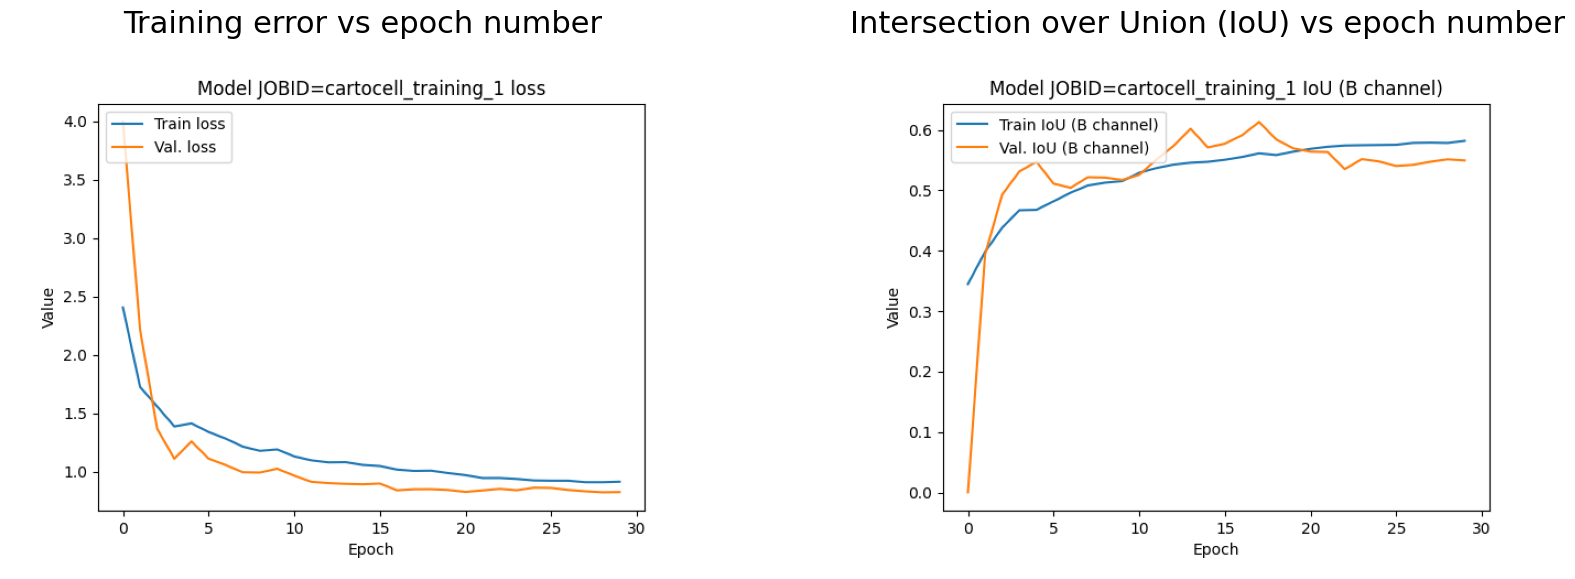

In [ ]:
#@markdown ##Play the cell to show a plot of training error vs. epoch number and IoU vs epoch number
import matplotlib.pyplot as plt

loss_plot = imread( output_path + '/'+job_name+'/results/'+job_name+'_1/charts/'+job_name+'_1_loss.png' )

channel_suffix = 'B'
iou_plot = imread( output_path + '/'+job_name+'/results/'+job_name+'_1/charts/'+job_name+'_1_IoU ('+channel_suffix+' channel).png' )
fig = plt.figure( figsize = (20,10))
ax1 = plt.subplot( 1, 2, 1 )
_ = plt.imshow( loss_plot )
_ = plt.axis('off')
ax1.set_title( 'Training error vs epoch number', fontdict = {'fontsize':22})

ax2 = plt.subplot( 1, 2, 2 )
_ = plt.imshow( iou_plot )
_ = plt.axis('off')
_= ax2.set_title( 'Intersection over Union (IoU) vs epoch number', fontdict = {'fontsize':22})

## **Visualize instance segmentation results (from the validation set)**
---

In [ ]:
#@markdown ###Play to visualize results from the validation set
#@markdown The current model will be applied to some validation images and results will be shown as browsable 2D stacks displaying:
#@markdown 1. The **Source image**.
#@markdown 2. Its corresponding **Ground truth** labels.
#@markdown 3. The model **Prediction** labels using watershed.
#@markdown 4. The model **Post-processed** labels using our Voronoi algorithm.
#@markdown 5. The **Overlay** between ground truth and post-processed labels.

%matplotlib inline
import matplotlib
import numpy as np
from numpy.random import randint, seed
from matplotlib import pyplot as plt
from ipywidgets import interact, fixed
import ipywidgets as widgets
from google.colab import output
output.enable_custom_widget_manager()

final_results = os.path.join(output_path, job_name, 'results', job_name + "_1")

instance_results = os.path.join(final_results, "per_image_instances")
post_results = os.path.join(final_results, "per_image_post_processing")

show_post = os.path.exists( post_results )

# Show a few examples to check that they have been stored correctly
ids_pred = sorted(next(os.walk(instance_results))[2])
ids_input = sorted(next(os.walk(val_data_path))[2])
ids_gt = sorted(next(os.walk(val_data_gt_path))[2])

# create random color map
vals = np.linspace(0,1,256)
np.random.shuffle(vals)
cmap = plt.cm.colors.ListedColormap(plt.cm.gist_rainbow(vals))
cmap.colors[0] = [0., 0., 0., 1.] # set background to black

samples_to_show = min(len(ids_input), 3)
chosen_images = np.random.choice(len(ids_input), samples_to_show, replace=False)
seed(1)

test_samples = []
test_sample_preds = []
test_sample_posts = []
test_sample_gt = []

# read 3D images again
for i in range(len(chosen_images)):
    aux = imread(os.path.join(val_data_path, ids_input[chosen_images[i]]))
    test_samples.append(aux)

    aux = imread(os.path.join(instance_results, ids_pred[chosen_images[i]])).astype(np.uint16)
    test_sample_preds.append(aux)

    if show_post:
        aux = imread(os.path.join(post_results, ids_pred[chosen_images[i]])).astype(np.uint16)
        test_sample_posts.append(aux)

    aux = imread(os.path.join(val_data_gt_path, ids_gt[chosen_images[i]])).astype(np.uint16)
    test_sample_gt.append(aux)

num_subplots = 5 if show_post else 4

# function to show results in 3D within a widget
def scroll_in_z(z, j):

    plt.figure(figsize=(25,5))
    # Source
    plt.subplot(1,num_subplots,1)
    plt.axis('off')
    plt.imshow(test_samples[j][z-1], cmap='gray')
    plt.title('Source (z = ' + str(z) + ')', fontsize=15)

    # Target (Ground-truth)
    plt.subplot(1,num_subplots,2)
    plt.axis('off')
    plt.imshow(test_sample_gt[j][z-1], cmap=cmap, interpolation='nearest')
    plt.title('Ground truth (z = ' + str(z) + ')', fontsize=15)

    # Prediction
    plt.subplot(1,num_subplots,3)
    plt.axis('off')
    plt.imshow(test_sample_preds[j][z-1], cmap=cmap, interpolation='nearest')
    plt.title('Prediction (z = ' + str(z) + ')', fontsize=15)

    # Post-processed
    if show_post:
        plt.subplot(1,num_subplots,4)
        plt.axis('off')
        plt.imshow(test_sample_posts[j][z-1], cmap=cmap, interpolation='nearest')
        plt.title('Post-processed (z = ' + str(z) + ')', fontsize=15)

    # Overlay
    plt.subplot(1,num_subplots,num_subplots)
    plt.axis('off')
    plt.imshow(test_sample_gt[j][z-1], cmap='Greens')
    plt.imshow(test_sample_posts[j][z-1], alpha=0.5, cmap='Purples')
    plt.title('Overlay (z = ' + str(z) + ')', fontsize=15)

    plt.show()

for j in range(samples_to_show):
    interact(scroll_in_z, z=widgets.IntSlider(min=1, max=test_sample_gt[j].shape[0], step=1, value=test_sample_gt[j].shape[0]//2), j=fixed(j));

interactive(children=(IntSlider(value=22, description='z', max=44, min=1), Output()), _dom_classes=('widget-in…

interactive(children=(IntSlider(value=25, description='z', max=51, min=1), Output()), _dom_classes=('widget-in…

In [ ]:
#@markdown ###Play to display the path to the output files (one 3D TIFF label image for each input image).

final_results = os.path.join(output_path, job_name, 'results', job_name+"_1")

instance_results = os.path.join(final_results, "per_image_instances")
post_results = os.path.join(final_results, "per_image_post_processing")

print("Output paths:")
print("    Instance segmentation files before post-processing are in {}".format(instance_results))
print("    Instance segmentation files after post-processing are in {}".format(post_results))

[14:58:41.968238] Output paths:
[14:58:41.969607]     Instance segmentation files before post-processing are in /content/output/cartocell_training/results/cartocell_training_1/per_image_instances
[14:58:41.970745]     Instance segmentation files after post-processing are in /content/output/cartocell_training/results/cartocell_training_1/per_image_post_processing


## **Download segmentation results**
---

In [ ]:
#@markdown ###Play to download a zip file with the segmentation results **before post-processing** in the validation set.

from google.colab import files

!zip -q -j /content/cartocell_val_segmentation_results_before.zip $instance_results/*.tif

files.download("/content/cartocell_val_segmentation_results_before.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@markdown ###Play to download a zip file with all **post-processed** segmentation results in the validation set.

from google.colab import files

!zip -q -j /content/cartocell_val_segmentation_results.zip $post_results/*.tif

files.download("/content/cartocell_val_segmentation_results.zip")


## **Download trained model (weights and configuration file)**
---
If you want to **reuse the trained model in the future**, you can download both the model weights and its configuration file (.YAML) by running the following cells.

In [ ]:
from google.colab import files

#@markdown ###Play to download the model weights

checkpoints_path = os.path.join(output_path, job_name, 'checkpoints')

weights_filename = str( job_name ) + '_1-checkpoint-best.pth'

files.download( os.path.join( checkpoints_path, weights_filename))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@markdown ###Play to download the model configuration file (.YAML)

config_path = os.path.join(output_path, job_name, 'config_files')

files.download( os.path.join( config_path, yaml_file))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **How to use the trained model with new data**
---
To directly infer new data to the trained model, you can use [this notebook](https://github.com/BiaPyX/BiaPy/blob/master/notebooks/BiaPy_Inference.ipynb). It will be necessary to upload the downloaded YAML configuration file and model weights to that notebook.

## **Acknowledgments**
---
We would like to express our gratitude for the inspiration drawn from the exceptional [ZeroCostDL4Mic notebooks](https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki). Specifically, we've adopted some of their metric and parameter descriptions, as well as the 3D visualization widget code present in their [U-Net 3D notebook](https://colab.research.google.com/github/HenriquesLab/ZeroCostDL4Mic/blob/master/Colab_notebooks/U-Net_3D_ZeroCostDL4Mic.ipynb). Additionally, our heartfelt thanks go out to [Estibaliz Gomez-de-Mariscal](https://scholar.google.es/citations?user=gsg-TAUAAAAJ) for her invaluable support and perceptive feedback, which significantly enhanced the quality of this notebook.
